In [16]:
from envs.cartpole_pret2 import Cartpole
from filters.NN_filters import FCN
import numpy as np
import matplotlib.pyplot as plt
import torch 
from tqdm import tqdm

env = Cartpole(0, 0, focus=0)
# initialize cartpole
steps_trajectory = 10
num_actions = 30
delta_t_steps = 10
num_states = 5000
states_whole_set = []
actions_whole_set = []
label_whole_set = []
for i in tqdm(range(num_states), desc="Training Epochs"):
    state,action, done = env.sample_data_real_trajectory2(steps_trajectory, num_actions)
    states_whole_set.append(state)
    actions_whole_set.append(action)
    labels = np.where(done,-1,1)
    label_whole_set.append(labels)
states_whole_set = np.concatenate(states_whole_set)
actions_whole_set = np.concatenate(actions_whole_set)
label_whole_set = np.concatenate(label_whole_set)
states_whole_set = states_whole_set.reshape(-1,4)
actions_whole_set= actions_whole_set.reshape(-1,num_actions,1)
label_whole_set = label_whole_set.reshape(-1,num_actions)
print(states_whole_set.shape)
print(actions_whole_set.shape)
print(label_whole_set.shape)
print((label_whole_set==-1).sum())
np.savez("exps/cartpole/training_dataTrajectories2.npz", train_states = states_whole_set, train_inputs = actions_whole_set, train_labels = label_whole_set)

Training Epochs: 100%|██████████| 5000/5000 [01:13<00:00, 68.34it/s]

(5000, 4)
(5000, 30, 1)
(5000, 30)
96502


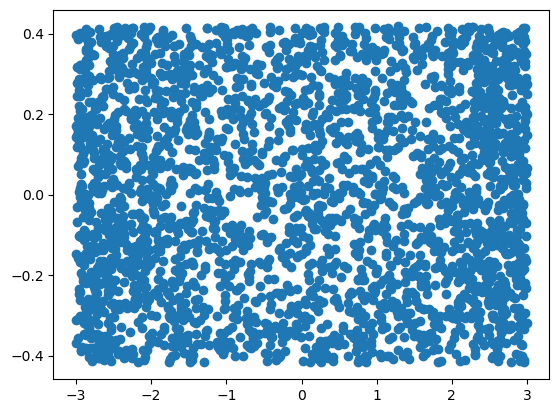

(4500, 30, 1)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
training_data = np.load("exps/cartpole/training_dataTrajectories2.npz")
train_states = training_data["train_states"]
train_inputs = training_data["train_inputs"].astype(np.float64)
train_labels = training_data["train_labels"]
train_size = int(train_states.shape[0]*0.9)
val_states = train_states[train_size:,:]
train_states = train_states[:train_size,:]
val_inputs = train_inputs[train_size:,:,:]
train_inputs = train_inputs[:train_size,:,:]
val_labels = train_labels[train_size:,:]
train_labels = train_labels[:train_size,:]
plt.scatter(train_states[(train_labels==-1)[:,0], 0], train_states[(train_labels==-1)[:,0], 2])
plt.show()
print(train_inputs.shape)

In [18]:
from envs.cartpole_pret2 import Cartpole
from filters.NN_filters import FCN
import numpy as np
import matplotlib.pyplot as plt
import torch 
from tqdm import tqdm
# initialize network
env = Cartpole(0, 0, focus=0)
input_size = 4
output_size = 2
n_layers = 5
size=1000
activation = 'relu'
lr = 5e-4
sc = 1
gamma_pos = 1
gamma_neg = 5
model = FCN(input_size, output_size, n_layers, size, activation, lr, sc, gamma_pos, gamma_neg)
model.FCN.train()

# train network
epochs = 5
num_log = 4

train_losses = []
val_losses = []
best_loss = float('inf')
print("Training model...")
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    for i in range(5):
        train_loss = model.update2(train_states, train_inputs, train_labels, env)
    model.scheduler.step()
    if epoch % 1 == 0:
        train_losses.append(train_loss)
        val_loss = model.get_val_loss(val_states, val_inputs, val_labels, env)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            torch.save({
            'model_state_dict': model.FCN.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            }, 'exps/cartpole/model.pth')
        train_losses = train_losses[-500:]
        val_losses = val_losses[-500:]
        print("epoch:", epoch, 'train loss:', train_loss)
        print("epoch:", epoch, 'val loss:', val_loss)

model.FCN.eval()

Training model...


Training Epochs:  20%|██        | 1/5 [00:02<00:08,  2.12s/it]

epoch: 0 train loss: 0.03881329028791232
epoch: 0 val loss: 0.02592552440744884


Training Epochs:  40%|████      | 2/5 [00:04<00:06,  2.08s/it]

epoch: 1 train loss: 0.010465444195707059
epoch: 1 val loss: 0.011163754423550987


Training Epochs:  60%|██████    | 3/5 [00:06<00:04,  2.03s/it]

epoch: 2 train loss: 0.006925864316755295
epoch: 2 val loss: 0.005832626623375061


Training Epochs:  80%|████████  | 4/5 [00:08<00:02,  2.02s/it]

epoch: 3 train loss: 0.0024577359785150714
epoch: 3 val loss: 0.005243314477742595


Training Epochs: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

epoch: 4 train loss: 0.00827008568435222
epoch: 4 val loss: 0.007392390887162462


Sequential(
  (0): Linear(in_features=4, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1000, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1000, out_features=2, bias=True)
  (11): Identity()
)

In [19]:
from torch.distributions.uniform import Uniform
import random
def actor(state):
    model.FCN.eval()
    a_h,b_h = model.forward(state)
    a = Uniform(-1, 1).sample().unsqueeze(dim=0)
    if a_h @ a < b_h:
        a = a - (((a_h @ a) - b_h) / torch.norm(a, dim=-1)) * a_h
    return a, a_h, b_h

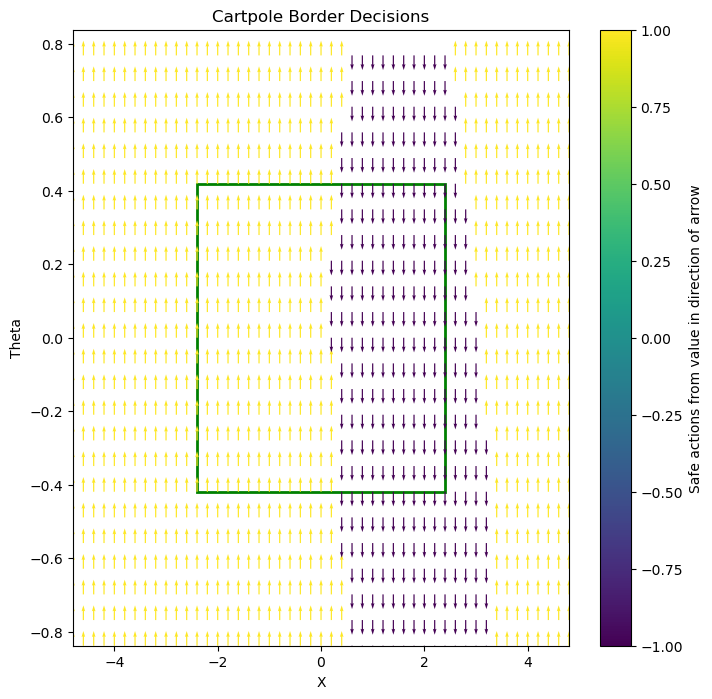

In [20]:
#Plot the hyperplanes in safe direction for all states
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
safe_radians = 24 * 2 * math.pi / 360
borders = []
arrowDirX=[]
arrowDirY=[]
safe_x=2.4
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colors = []
for x in np.arange(-2.4-2.4,2.5+2.4,0.2):
    for theta in np.arange(-safe_radians*2,safe_radians*2,math.pi / 360 *8):
        o=[x,1,theta,1]
        a, a_h, b_h = actor(o)
        borders.append([x,theta])
        a_h = a_h.detach().numpy()
        b_h = b_h.detach().numpy()
        threshold = np.clip((b_h/a_h),-1,1)
        if(a_h>0):
            to_right_is_dangerous = False
        else:
            to_right_is_dangerous = True
        if to_right_is_dangerous:
            arrowDirX.append(0)
            arrowDirY.append(-1)
            colors.append(threshold)
        else:
            arrowDirX.append(0)
            arrowDirY.append(1)
            colors.append(threshold)
borders = np.array(borders)
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
quiver_plot=plt.quiver(borders[:,0], borders[:,1], arrowDirX, arrowDirY,colors, cmap ="viridis", angles='xy', scale_units='xy', scale=25)
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(quiver_plot, label="Safe actions from value in direction of arrow")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()

-3.5999999999999996
-0.6283185307179586
[-0.30747724]
[-3.6         0.         -0.62831853  0.        ]
-3.5999999999999996
-0.4886921905584123
[0.25813127]
[-3.6         0.         -0.48869219  0.        ]
-3.5999999999999996
-0.34906585039886595
[0.5601964]
[-3.6         0.         -0.34906585  0.        ]
-3.5999999999999996
-0.20943951023931962
[-0.8162549]
[-3.6         0.         -0.20943951  0.        ]
-3.5999999999999996
-0.06981317007977328
[-0.8097518]
[-3.6         0.         -0.06981317  0.        ]
-3.5999999999999996
0.06981317007977306
[0.89886147]
[-3.6         0.          0.06981317  0.        ]
-3.5999999999999996
0.2094395102393194
[-0.4115955]
[-3.6         0.          0.20943951  0.        ]
-3.5999999999999996
0.34906585039886573
[-0.5116142]
[-3.6         0.          0.34906585  0.        ]
-3.5999999999999996
0.48869219055841207
[-0.05492096]
[-3.6         0.          0.48869219  0.        ]
-3.1999999999999997
-0.6283185307179586
[0.98223996]
[-3.2         0. 

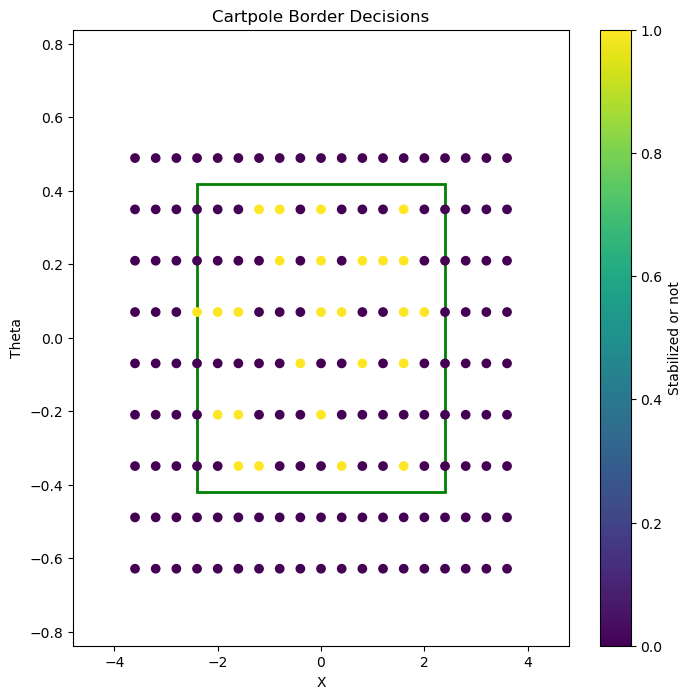

In [ ]:

# initialize network
env = Cartpole(0, 0, focus=0)
safe_radians = 24 * 2 * math.pi / 360
borders=[]
colors=[]
for x in np.arange(-2.4-1.2,2.5+1.2,0.4):
    for theta in np.arange(-safe_radians*1.5,safe_radians*1.5,math.pi / 360 *16):
        print(x)
        print(theta)
        o = env.reset([x,0,theta,0])
        steps = 0
        done = False
        while not done and steps <=20:
            a, a_h, b_h = actor(o)
         (500, 4, 1)   a_h = a_h.detach().numpy()
            b_h = b_h.detach().numpy()
            a = a.detach().numpy()
            a = a.reshape(-1)
            threshold = np.clip((b_h/a_h)[0],-1,1)
            next_o, r, d, info = env.step(a)
            done = d
            steps +=1
            print(a)
            print(o)
            o = next_o
        borders.append([x,theta])
        if done: 
            colors.append(0)
        else:
            colors.append(1)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
borders = np.array(borders)
safe_x = 2.4
safe_radians = 24 * 2 * math.pi / 360
rectangle = patches.Rectangle((-safe_x, -safe_radians), 2*safe_x, 2*safe_radians, linewidth=2, edgecolor='green', facecolor='white')
ax.add_patch(rectangle)
scatter_plot=plt.scatter(borders[:,0], borders[:,1],c= colors, cmap="viridis")
# This are the borders of the simulation
plt.axis([-2*safe_x, 2*safe_x, -2*safe_radians, 2*safe_radians])
plt.colorbar(scatter_plot, label="Stabilized or not")            
plt.xlabel("X")
plt.ylabel("Theta")
plt.title("Cartpole Border Decisions")
plt.show()  # Close plot to avoid replotting issues

In [ ]:
#Cartpole Vec not working theta calc must be wrong
from envs.cartpole_pret_Vector import CartpoleVec
import time
env = CartpoleVec(disc_steps=20, vector_size=5)
o = env.reset()
#a =  env.np_random.uniform(low=-0.05, high=0.05, size=(5,1))
for i in range(100):
    a = env.action_space.sample()/100
    env.step(a)
    env.render()
    time.sleep(0.2)


/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
